# Pretraining (Masked LM + NSP)

## PROCESS OVERVIEW



| Step | Penjelasan                           | Status |
| :--: | :----------------------------------- | :----: |
|   1  | Bangun Mini-BERT Stack               |    ✅   |
|   2  | Pretraining (Masked LM + NSP)        |   NOW   |
|   3  | Fine-tuning ke task spesifik         |   🔜   |
|   4  | Buat dataset dummy buat latihan      |   🔜   |
|   5  | Build mindset & intuition level dewa |   🔜   |

---

INTI :

- Input: Token yang di-mask sebagian + sepasang kalimat
- Target 1: Isi kata yang di-mask
- Target 2: Apakah kalimat kedua nyambung?

HOW? :

- Tokenisasi kalimat ➔ jadi token ID

- Tambahin [CLS] di awal, [SEP] antar kalimat

- Tambahin Positional Encoding kayak biasa

- Random pilih token buat di-[MASK] (sekitar 15% token)

- Masukin ke Mini-BERT stack - model kita

- Output 1: Prediksi isi token yang ketutup

- Output 2: Prediksi label NSP (IsNext / NotNext)




| Misi                              | Tujuan                         | Gampangnya                                     |
| :-------------------------------- | :----------------------------- | :--------------------------------------------- |
| 1. Masked Language Model (MLM)    | Belajar isi kata yang hilang   | Tebak kata yang ketutupan                      |
| 2. Next Sentence Prediction (NSP) | Belajar hubungan antar kalimat | Tebak apakah kalimat kedua nyambung atau ngaco |


---

# MLM : MASK LANGUAGE MODEL


## INTUITION

- Belajar isi kata yang hilang, tutup beberapa kata dalam kalimat
- Tebak kata yang ketutupan , suruh bert nebak itu
- Kalimat asli:
- "Saya makan nasi di warung."

- Setelah masking:
- "Saya [MASK] nasi di [MASK]."

- Tugas BERT:
- Tebak [MASK] = "makan", [MASK] = "warung"


## PROCESS

1. Input :

- c = ['kucing bermain di taman']

- t = ['kucing', 'bermain', 'di', 'taman']


2. Special Token :

- ['[CLS]', 'kucing', 'bermain', 'di', 'taman', '[SEP]']


3. Masking 15% Input :

- ['[CLS]', 'kucing', '[MASK]', 'di', 'taman', '[SEP]']

4. Pretrain Model with this Approach :

- Input : ['[CLS]', 'kucing', '[MASK]', 'di', 'taman', '[SEP]']
  
- Embedding (token embedding + positional embedding),
  
- Stack Encoder stack (MHA ➔ AddNorm ➔ FFN ➔ AddNorm),

- keluar tensor representasi semua token.


## PSEUDOCODE

    # pretraining bert for mlm
    initialize bert model with random weight

    def apply mask (tokens):
        for i in range (len token):
            if random < 0.15:
                if random < 0.8:
                    tokens[i] = [mask]
                elif random < 0.9:
                    token[i] = random_token()
                else:
                    token[i] = token[i]
                lebel[i] = original token
            else:
                label[i] = [ignore]

        return tokens, label
    
    for each epoch:
        for each batch in training data :
        # 1. tokenize
        input token = tokenize(batch)

        # 2. masking
        mask input, label = apply mask (input token)

        # 3. feed forward bert
        output = bertmodel(mask input)

        # 4. training, loss 
        loss = cross entropy(output[mask position], labels[mask position])

        # 5. backpropagation or update parameter
        loss.backward()
        optimizer.step()
        optimizer.zero grad()


## EXAMPLE

1. Input : ['[CLS]', 'singa', 'berlari', 'cepat', '[SEP]']

2. Mask :['[CLS]', 'singa', '[MASK]', 'cepat', '[SEP]']

3. Embedding :

- [CLS]:  [0.1, 0.2]

- singa:  [0.5, 0.4]

- [MASK]: [0.0, 0.0]  (karena belum tahu)

- cepat:  [0.3, 0.7]

- [SEP]:  [0.1, 0.2]


4. BERT Model :

- MHA ➔ AddNorm

- FFN ➔ AddNorm

- [MASK]: [0.48, 0.45]


5. Loss :

- Vocab :
{
  'singa':  [0.5, 0.4],
  'berlari': [0.48, 0.45],
  'cepat': [0.3, 0.7],
  'makan': [0.7, 0.2]
}

- Similarity

- ke 'singa' ➔ 0.48×0.5 + 0.45×0.4 = 0.24 + 0.18 = 0.42

- ke 'berlari' ➔ 0.48×0.48 + 0.45×0.45 = 0.2304 + 0.2025 = 0.4329

- ke 'cepat' ➔ 0.48×0.3 + 0.45×0.7 = 0.144 + 0.315 = 0.459

- ke 'makan' ➔ 0.48×0.7 + 0.45×0.2 = 0.336 + 0.09 = 0.426


--

## NEXT SENTENCE PREDICTION (NSP)

- Dikasih dua kalimat, suruh BERT tebak:

- Nyambung? (A ➔ B)

- Atau ngaco? (A ➔ random)

- Kalimat 1: "Saya pergi ke pasar."
- Kalimat 2: "Saya membeli buah."
- ==> Label: IsNext (nyambung)

- Kalimat 1: "Saya pergi ke pasar."
- Kalimat 2: "Bulan purnama sangat indah."
- ==> Label: NotNext (acak)


## PYTHON CODE IMPLEMENTATION OF PRETRAIN BERT MODEL

src = https://www.101ai.net/text/bert



### Data

In [275]:
import numpy as np

corpus = 'i like playing pussies'
vocab = corpus.split()
vocab.insert(0, '[CLS]')
vocab.extend(['[MASK]', '[SEP]'])
vocab

['[CLS]', 'i', 'like', 'playing', 'pussies', '[MASK]', '[SEP]']

In [276]:
token2idx = {}
idx2token = {}

for idx, token in enumerate(vocab):
    token2idx[token] = idx
    idx2token[idx] = token

print(token2idx)
print()
print(idx2token)

{'[CLS]': 0, 'i': 1, 'like': 2, 'playing': 3, 'pussies': 4, '[MASK]': 5, '[SEP]': 6}

{0: '[CLS]', 1: 'i', 2: 'like', 3: 'playing', 4: 'pussies', 5: '[MASK]', 6: '[SEP]'}


In [277]:
token2idx = {token : idx for idx, token in enumerate(vocab)}
idx2token = {idx : token for token, idx in token2idx.items()}

print(token2idx)
print()
print(idx2token)

{'[CLS]': 0, 'i': 1, 'like': 2, 'playing': 3, 'pussies': 4, '[MASK]': 5, '[SEP]': 6}

{0: '[CLS]', 1: 'i', 2: 'like', 3: 'playing', 4: 'pussies', 5: '[MASK]', 6: '[SEP]'}


### Mask and Tokenize

In [278]:
tokens = corpus.split()
tokens.insert(0, '[CLS]')
tokens.append('[SEP]')
tokens[tokens.index('playing')] = '[MASK]'
tokens

['[CLS]', 'i', 'like', '[MASK]', 'pussies', '[SEP]']

In [279]:
token_ids = [token2idx[t] for t in tokens]
token_ids

[0, 1, 2, 5, 4, 6]

### Embedding

In [283]:
scale = 0.1
d_model = 4

np.random.seed(42)
embed_matrix = np.random.rand(len(vocab), d_model) * scale
embed_matrix

array([[0.03745401, 0.09507143, 0.07319939, 0.05986585],
       [0.01560186, 0.01559945, 0.00580836, 0.08661761],
       [0.0601115 , 0.07080726, 0.00205845, 0.09699099],
       [0.08324426, 0.02123391, 0.0181825 , 0.01834045],
       [0.03042422, 0.05247564, 0.0431945 , 0.02912291],
       [0.06118529, 0.01394939, 0.02921446, 0.03663618],
       [0.045607  , 0.0785176 , 0.01996738, 0.05142344]])

In [286]:
embed_matrixs = []
for token, its_id in zip(tokens, token_ids):
    print(f"Token: {token}")
    print(f"ID   : {its_id}")
    print(f"Embed: {embed_matrix[its_id]}\n")
    embed_matrixs.append(embed_matrix[its_id])

Token: [CLS]
ID   : 0
Embed: [0.03745401 0.09507143 0.07319939 0.05986585]

Token: i
ID   : 1
Embed: [0.01560186 0.01559945 0.00580836 0.08661761]

Token: like
ID   : 2
Embed: [0.0601115  0.07080726 0.00205845 0.09699099]

Token: [MASK]
ID   : 5
Embed: [0.06118529 0.01394939 0.02921446 0.03663618]

Token: pussies
ID   : 4
Embed: [0.03042422 0.05247564 0.0431945  0.02912291]

Token: [SEP]
ID   : 6
Embed: [0.045607   0.0785176  0.01996738 0.05142344]



### Positional Encoding

In [154]:
len_ids = len(token_ids) + 1

pos = np.arange(len_ids).reshape(len_ids,1)
i = np.arange(1,d_model)

pos, i

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6]]),
 array([1, 2, 3]))

In [155]:
angle_rates = 1 / np.power(10000, (2*(i//2))/4)
angle_rads = pos * angle_rates


print(angle_rates)
print()
print(angle_rads)

[1.   0.01 0.01]

[[0.   0.   0.  ]
 [1.   0.01 0.01]
 [2.   0.02 0.02]
 [3.   0.03 0.03]
 [4.   0.04 0.04]
 [5.   0.05 0.05]
 [6.   0.06 0.06]]


In [156]:
pos_encoding = np.zeros((len_ids, d_model))
pos_encoding

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [157]:
pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
pos_encoding

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.84147098,  0.        ,  0.00999983,  0.        ],
       [ 0.90929743,  0.        ,  0.01999867,  0.        ],
       [ 0.14112001,  0.        ,  0.0299955 ,  0.        ],
       [-0.7568025 ,  0.        ,  0.03998933,  0.        ],
       [-0.95892427,  0.        ,  0.04997917,  0.        ],
       [-0.2794155 ,  0.        ,  0.05996401,  0.        ]])

In [158]:
pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
pos_encoding

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.84147098,  0.99995   ,  0.00999983,  0.99995   ],
       [ 0.90929743,  0.99980001,  0.01999867,  0.99980001],
       [ 0.14112001,  0.99955003,  0.0299955 ,  0.99955003],
       [-0.7568025 ,  0.99920011,  0.03998933,  0.99920011],
       [-0.95892427,  0.99875026,  0.04997917,  0.99875026],
       [-0.2794155 ,  0.99820054,  0.05996401,  0.99820054]])

In [159]:
len(pos_encoding), len(embed_matrix)

(7, 7)

In [173]:
input_embedding = pos_encoding + embed_matrix
input_embedding.shape

(7, 4)

### Single Head Self Attention

In [162]:
scale = 0.1

np.random.seed(0)
wq = np.random.rand(d_model, d_model) * scale
wk = np.random.rand(d_model, d_model) * scale
wv = np.random.rand(d_model, d_model) * scale

wq, wk, wv

(array([[0.05488135, 0.07151894, 0.06027634, 0.05448832],
        [0.04236548, 0.06458941, 0.04375872, 0.0891773 ],
        [0.09636628, 0.03834415, 0.0791725 , 0.05288949],
        [0.05680446, 0.09255966, 0.00710361, 0.00871293]]),
 array([[0.00202184, 0.08326198, 0.07781568, 0.08700121],
        [0.09786183, 0.07991586, 0.04614794, 0.07805292],
        [0.01182744, 0.0639921 , 0.01433533, 0.09446689],
        [0.05218483, 0.04146619, 0.02645556, 0.07742337]]),
 array([[0.04561503, 0.05684339, 0.00187898, 0.06176355],
        [0.06120957, 0.0616934 , 0.09437481, 0.06818203],
        [0.03595079, 0.0437032 , 0.06976312, 0.00602255],
        [0.06667667, 0.06706379, 0.02103826, 0.01289263]]))

In [163]:
q = input_embedding @ wq
k = input_embedding @ wk
v = input_embedding @ wv

q,k,v

(array([[0.11570781, 0.17431629, 0.06350076, 0.11280234],
        [0.15330681, 0.22806917, 0.10507048, 0.14756769],
        [0.16298744, 0.24084536, 0.11481831, 0.15901818],
        [0.11802287, 0.17804107, 0.06923712, 0.11467291],
        [0.07111957, 0.11434816, 0.01612724, 0.06756573],
        [0.06008054, 0.10007597, 0.00382696, 0.05460329],
        [0.10010996, 0.1530406 , 0.04680717, 0.09665181]]),
 array([[0.16341611, 0.13926485, 0.08253848, 0.17770537],
        [0.15800572, 0.19858751, 0.14253159, 0.23945205],
        [0.16422831, 0.21316464, 0.15417394, 0.2549047 ],
        [0.15403768, 0.14554889, 0.09218564, 0.18255487],
        [0.15609701, 0.07152962, 0.02040638, 0.10636492],
        [0.15225769, 0.05418453, 0.00540283, 0.08858406],
        [0.16061672, 0.11521838, 0.06040859, 0.15251566]]),
 array([[0.14203722, 0.14396536, 0.13082188, 0.09108279],
        [0.17427378, 0.18493184, 0.12141502, 0.136282  ],
        [0.18367438, 0.19567282, 0.1274732 , 0.14714367],
        [0

In [177]:
def softmax(x):
    ex = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return(ex/np.sum(ex, axis=-1, keepdims=True))

In [178]:
qk = (q@k.T)/(d_model)**0.5

print(f"qk.shape : {qk.shape}")
qk

qk.shape : (7, 7)


array([[0.03423574, 0.04448057, 0.04735229, 0.03482069, 0.02191223,
        0.01869911, 0.02985458],
       [0.04585538, 0.05991315, 0.06380421, 0.04671772, 0.02904229,
        0.02466989, 0.03987747],
       [0.04895569, 0.06401215, 0.06817167, 0.04988756, 0.03096321,
        0.0262865 , 0.04255855],
       [0.03508721, 0.04566608, 0.04861999, 0.03570521, 0.02238414,
        0.01907461, 0.03057099],
       [0.02044234, 0.02621141, 0.02788203, 0.02070975, 0.01339828,
        0.01154839, 0.01793853],
       [0.01688718, 0.02149362, 0.02285412, 0.01707075, 0.01121138,
        0.00971398, 0.01486978],
       [0.02935585, 0.03801244, 0.04045859, 0.0298274 , 0.01890467,
        0.01617482, 0.02564045]])

In [179]:
scores = softmax(qk)
scores

array([[0.14301958, 0.14449232, 0.14490786, 0.14310327, 0.14126789,
        0.14081471, 0.14239436],
       [0.14307103, 0.14509649, 0.14566217, 0.14319446, 0.14068567,
        0.14007188, 0.14221831],
       [0.1430844 , 0.14525505, 0.1458605 , 0.1432178 , 0.14053298,
        0.13987728, 0.14217199],
       [0.14302337, 0.14454443, 0.14497203, 0.14311179, 0.14121803,
        0.14075144, 0.14237891],
       [0.14295627, 0.14378338, 0.14402379, 0.1429945 , 0.14195282,
        0.14169046, 0.14259878],
       [0.14293958, 0.14359954, 0.14379504, 0.14296582, 0.14213058,
        0.14191792, 0.14265151],
       [0.14299747, 0.14424072, 0.14459398, 0.14306492, 0.14151076,
        0.14112499, 0.14246716]])

In [183]:
attn_output = scores @ v

print(f"scores.shape : {scores.shape}")
print()
print(f"output.shape : {attn_output.shape}")
attn_output

scores.shape : (7, 7)

output.shape : (7, 4)


array([[0.13832397, 0.14012537, 0.1252328 , 0.08789334],
       [0.13843667, 0.1402644 , 0.12523444, 0.08804333],
       [0.13846624, 0.14030088, 0.12523488, 0.08808268],
       [0.1383336 , 0.14013725, 0.12523293, 0.08790617],
       [0.13819153, 0.13996198, 0.12523083, 0.08771708],
       [0.13815719, 0.13991961, 0.12523032, 0.08767138],
       [0.13827699, 0.14006741, 0.1252321 , 0.08783082]])

### Add and Norm


In [184]:
def norm(x):
    eps = 1e-6
    avg = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return (x - avg)/(std+eps)

add = attn_output + input_embedding
add

array([[ 0.17577798,  1.2351968 ,  0.19843219,  1.14775919],
       [ 0.99550951,  1.15581385,  0.14104264,  1.17461094],
       [ 1.10787516,  1.21090815,  0.14729199,  1.18487367],
       [ 0.36269787,  1.1609212 ,  0.17341092,  1.10579665],
       [-0.58818674,  1.19163773,  0.20841467,  1.1160401 ],
       [-0.7595818 ,  1.15261926,  0.20442396,  1.12305782],
       [-0.09553151,  1.21678555,  0.20516349,  1.13745481]])

In [187]:
norm_output = norm(add)
norm_output, norm_output.shape

(array([[-1.02049228,  1.08486346, -0.97547215,  0.91110096],
        [ 0.30317234,  0.68060205, -1.70863337,  0.72485899],
        [ 0.43994389,  0.67223463, -1.72571771,  0.61353918],
        [-0.77130081,  1.05016158, -1.20323389,  0.92437312],
        [-1.46799378,  0.97347617, -0.3752577 ,  0.86977531],
        [-1.51444963,  0.91969673, -0.28731345,  0.88206635],
        [-1.24426519,  1.05070511, -0.71841202,  0.9119721 ]]),
 (7, 4))

### FFN

In [203]:
scale = 0.1
d_ff = 8

np.random.seed(1)
wx = np.random.rand(d_model, d_ff) * scale
bx = np.zeros(d_ff,) 
wc = np.random.rand(d_ff, d_model) * scale
bc = np.zeros(d_model,)

wx.shape, wx, bx.shape, bx, wc.shape, wc, bc.shape, bc

((4, 8),
 array([[4.17022005e-02, 7.20324493e-02, 1.14374817e-05, 3.02332573e-02,
         1.46755891e-02, 9.23385948e-03, 1.86260211e-02, 3.45560727e-02],
        [3.96767474e-02, 5.38816734e-02, 4.19194514e-02, 6.85219500e-02,
         2.04452250e-02, 8.78117436e-02, 2.73875932e-03, 6.70467510e-02],
        [4.17304802e-02, 5.58689828e-02, 1.40386939e-02, 1.98101489e-02,
         8.00744569e-02, 9.68261576e-02, 3.13424178e-02, 6.92322616e-02],
        [8.76389152e-02, 8.94606664e-02, 8.50442114e-03, 3.90547832e-03,
         1.69830420e-02, 8.78142503e-02, 9.83468338e-03, 4.21107625e-02]]),
 (8,),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 (8, 4),
 array([[0.09578895, 0.05331653, 0.06918771, 0.03155156],
        [0.06865009, 0.08346257, 0.00182883, 0.07501443],
        [0.09888611, 0.07481657, 0.0280444 , 0.07892793],
        [0.0103226 , 0.04478935, 0.09085955, 0.02936141],
        [0.02877753, 0.01300286, 0.0019367 , 0.06788355],
        [0.02116281, 0.02655467, 0.04915732, 0.005336

In [204]:
ff1 = norm_output @ wx + bx
ff1, ff1.shape

(array([[ 0.03962806,  0.01195476,  0.03951924,  0.02771819, -0.05543318,
          0.0713971 , -0.0376498 ,  0.00830538],
        [ 0.03187079,  0.02789698,  0.01071146,  0.02478471, -0.10614328,
         -0.03922315, -0.03891304, -0.03165959],
        [ 0.02677359,  0.02638489,  0.00917571,  0.0275732 , -0.10756572,
         -0.05012466, -0.03801871, -0.03336486],
        [ 0.04030158,  0.01649736,  0.0349828 ,  0.02841406, -0.07049814,
          0.04976305, -0.04011147, -0.00061975],
        [ 0.03797228,  0.00355475,  0.0429196 ,  0.01828523, -0.01691786,
          0.1119713 , -0.02788429,  0.02518728],
        [ 0.0386483 ,  0.00332362,  0.04200382,  0.01498584, -0.01144833,
          0.1164145 , -0.0260196 ,  0.02658237],
        [ 0.03974453,  0.00843496,  0.04170098,  0.02370801, -0.03881681,
          0.09129795, -0.03384589,  0.016116  ]]),
 (7, 8))

In [205]:
ff2 = np.maximum(0,ff1)
ff2, ff2.shape

(array([[0.03962806, 0.01195476, 0.03951924, 0.02771819, 0.        ,
         0.0713971 , 0.        , 0.00830538],
        [0.03187079, 0.02789698, 0.01071146, 0.02478471, 0.        ,
         0.        , 0.        , 0.        ],
        [0.02677359, 0.02638489, 0.00917571, 0.0275732 , 0.        ,
         0.        , 0.        , 0.        ],
        [0.04030158, 0.01649736, 0.0349828 , 0.02841406, 0.        ,
         0.04976305, 0.        , 0.        ],
        [0.03797228, 0.00355475, 0.0429196 , 0.01828523, 0.        ,
         0.1119713 , 0.        , 0.02518728],
        [0.0386483 , 0.00332362, 0.04200382, 0.01498584, 0.        ,
         0.1164145 , 0.        , 0.02658237],
        [0.03974453, 0.00843496, 0.04170098, 0.02370801, 0.        ,
         0.09129795, 0.        , 0.016116  ]]),
 (7, 8))

In [206]:
ff3 = ff2 @ wc + bc
ff3, ff3.shape

(array([[0.01040661, 0.00954859, 0.01047681, 0.00680511],
        [0.00628306, 0.00593908, 0.00480841, 0.0046714 ],
        [0.00556792, 0.00555111, 0.00466327, 0.0043578 ],
        [0.00979874, 0.00873703, 0.00882752, 0.00637006],
        [0.01094164, 0.01036757, 0.01275197, 0.00702989],
        [0.01097422, 0.01034379, 0.01278815, 0.00694622],
        [0.01085157, 0.01009651, 0.01169589, 0.0070289 ]]),
 (7, 4))

### Mask Prediction

In [216]:
mask_id = tokens.index('[MASK]')
mask_vector =  ff3[mask]
a = '->'

mask_id, a, mask_vector

(3, '->', array([0.00979874, 0.00873703, 0.00882752, 0.00637006]))

In [217]:
embed_matrix[mask_id]

array([0.08324426, 0.02123391, 0.0181825 , 0.01834045])

In [253]:
scores = embed_matrix @ mask_vector
scores

array([0.00222516, 0.0008922 , 0.00184367, 0.00127855, 0.00132342,
       0.00121268, 0.00163674])

In [247]:
mask_id_predicted = np.argmax(scores)
mask_id_predicted

0

In [224]:
predicted_token = idx2token[mask_id_predicted]
predicted_token

'[CLS]'

In [242]:
print(f'mask_y_origin = {idx2token[3]}')
print(f'd_origin = {token2idx['playing']}')
print(f'mask_y_pred = {idx2token[mask_id_predicted]}')
print(f'd_origin = {token2idx[predicted_token]}')

mask_y_origin = playing
d_origin = 3
mask_y_pred = [CLS]
d_origin = 0


### Training

In [254]:
logits = scores
probs = softmax(logits)
probs

array([0.14296255, 0.14277212, 0.14290802, 0.14282728, 0.14283369,
       0.14281788, 0.14287845])

In [258]:
label = token2idx['playing']
loss = -np.log(probs[label])
loss

1.9461191762252408

In [ ]:
vocab_size = len(vocab)
d_model = 32
num_heads = 2
d_ff = 64
len_ids = len(token_ids)
lr = 0.01
num_epochs = 1000

embed_matrix = np.random.randn(vocab_size, embed_dim) * 0.01
position_embeddings = np.random.randn(seq_len, embed_dim) * 0.01

Wq = np.random.randn(embed_dim, embed_dim) * 0.01
Wk = np.random.randn(embed_dim, embed_dim) * 0.01
Wv = np.random.randn(embed_dim, embed_dim) * 0.01
Wo = np.random.randn(embed_dim, embed_dim) * 0.01

W1 = np.random.randn(embed_dim, ffn_dim) * 0.01
W2 = np.random.randn(ffn_dim, embed_dim) * 0.01

vocab_weights = np.random.randn(embed_dim, vocab_size) * 0.01

input_ids = token_ids
true_label = 'playing'

In [ ]:
scale = 0.1
d_model = 4

np.random.seed(42)
embed_matrix = np.random.rand(len(vocab), d_model) * scale
embed_matrix + 

In [ ]:
for epoch in range(num_epochs):
    # word embedding
    embed_matrix 

Epoch 10/1000, Loss: 2.2220
Current prediction: playing, Target: playing
Epoch 20/1000, Loss: 2.1333
Current prediction: playing, Target: playing
Epoch 30/1000, Loss: 2.0457
Current prediction: playing, Target: playing
Epoch 40/1000, Loss: 1.9591
Current prediction: playing, Target: playing
Epoch 50/1000, Loss: 1.8738
Current prediction: playing, Target: playing
Epoch 60/1000, Loss: 1.7898
Current prediction: playing, Target: playing
Epoch 70/1000, Loss: 1.7072
Current prediction: playing, Target: playing
Epoch 80/1000, Loss: 1.6260
Current prediction: playing, Target: playing
Epoch 90/1000, Loss: 1.5465
Current prediction: playing, Target: playing
Epoch 100/1000, Loss: 1.4686
Current prediction: playing, Target: playing
Epoch 110/1000, Loss: 1.3925
Current prediction: playing, Target: playing
Epoch 120/1000, Loss: 1.3182
Current prediction: playing, Target: playing
Epoch 130/1000, Loss: 1.2459
Current prediction: playing, Target: playing
Epoch 140/1000, Loss: 1.1757
Current prediction

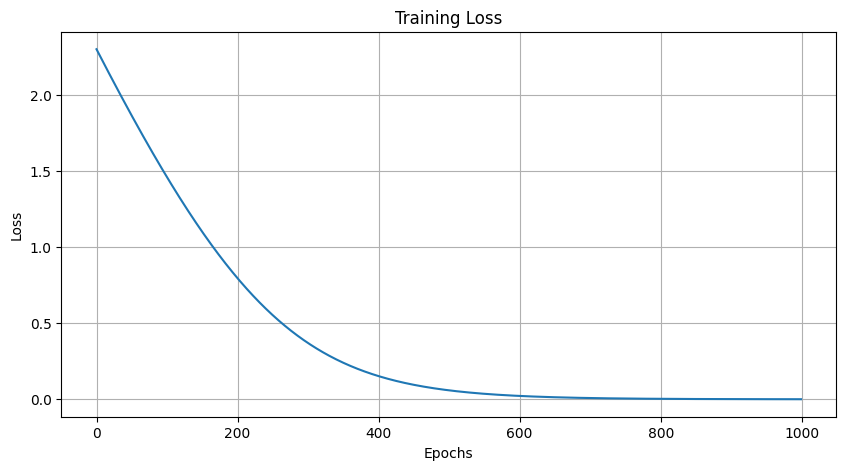

In [17]:
import numpy as np

# Your existing functions
def data(corpus):    
    vocab = corpus.split()    
    vocab.insert(0, '[CLS]')    
    vocab.extend(['[SEP]', '[MASK]'])    
    return vocab

def tokennizer(vocab):    
    token2idx = {}    
    idx2token = {}    
    for idx, token in enumerate(vocab):        
        token2idx[token] = idx        
        idx2token[idx] = token    
    return token2idx, idx2token

def masking(corpus):    
    tokens = corpus.split()    
    tokens.insert(0, '[CLS]')    
    tokens.extend(['[SEP]', '[MASK]'])    
    labels = 'playing'    
    tokens[tokens.index(labels)] = '[MASK]'    
    return tokens

def token_ids(tokens, token2idx):    
    token_ids = []    
    for token in tokens:        
        token_ids.append(token2idx[token])    
    return token_ids, len(token_ids)

def embedding(scale, d_model, vocab_size):    
    np.random.seed(42)    
    embed_matrix = np.random.rand(vocab_size, d_model) * scale    
    return embed_matrix

def position_embedding(seq_len, d_model, vocab_size):    
    pos = np.arange(seq_len).reshape(seq_len,1)    
    i = np.arange(d_model)   
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))    
    angle_rads = pos * angle_rates    
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])    
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])            
    return pe

def embedding_output(embed_matrix, position_embedding):    
    return embed_matrix + position_embedding

def attention_weights(d_model):    
    Wq = np.random.randn(d_model, d_model) * 0.01    
    Wk = np.random.randn(d_model, d_model) * 0.01    
    Wv = np.random.randn(d_model, d_model) * 0.01    
    return Wq, Wk, Wv

def attention_output(x, Wq, Wk, Wv):    
    Q = x @ Wq    
    K = x @ Wk    
    V = x @ Wv    
    d_k = Q.shape[-1]    
    scaled = np.matmul(Q, K.transpose()) / np.sqrt(d_k)    
    softmax = np.exp(scaled) / np.sum(np.exp(scaled), axis=-1, keepdims=True)    
    return np.matmul(softmax, V)

def add_and_norm(x, attention_output):    
    eps = 1e1    
    avg = np.mean(x, axis=-1, keepdims=True)    
    std = np.std(x, axis=-1, keepdims=True)    
    norm = (x - avg) / (std + eps)    
    norm_output = attention_output + norm    
    return norm_output    

def ffn_weights(d_model, d_ff):    
    W1 = np.random.randn(d_model, d_ff) * 0.01    
    W2 = np.random.randn(d_ff, d_model) * 0.01    
    return W1, W2

def ffn_output(norm_output, W1, W2):    
    ffn_output = np.matmul(norm_output, W1)    
    relu = np.maximum(0, ffn_output)    
    ffn_output = np.matmul(relu, W2)    
    return ffn_output

# New functions for the training loop

def initialize_model(d_model, d_ff, vocab_size):
    """Initialize all model weights"""
    scale = 0.01
    Wq, Wk, Wv = attention_weights(d_model)
    W1, W2 = ffn_weights(d_model, d_ff)
    embed_matrix = embedding(scale, d_model, vocab_size)
    
    # Output layer for masked language modeling
    W_output = np.random.randn(d_model, vocab_size) * 0.01
    b_output = np.zeros(vocab_size)
    
    return {
        'Wq': Wq, 'Wk': Wk, 'Wv': Wv,
        'W1': W1, 'W2': W2,
        'embed_matrix': embed_matrix,
        'W_output': W_output,
        'b_output': b_output
    }

def forward_pass(token_ids_input, seq_len, model_params, d_model, vocab_size):
    """Forward pass through the model"""
    # Convert token IDs to one-hot matrix for embedding lookup
    input_matrix = np.zeros((seq_len, len(model_params['embed_matrix'])))
    for i, idx in enumerate(token_ids_input):
        input_matrix[i, idx] = 1
    
    # Get token embeddings
    token_embeds = input_matrix @ model_params['embed_matrix']
    
    # Add positional encoding
    pos_enc = position_embedding(seq_len, d_model, vocab_size)
    x = embedding_output(token_embeds, pos_enc)
    
    # Transformer layer
    attn_out = attention_output(x, model_params['Wq'], model_params['Wk'], model_params['Wv'])
    norm1 = add_and_norm(x, attn_out)
    ffn_out = ffn_output(norm1, model_params['W1'], model_params['W2'])
    encoder_output = add_and_norm(norm1, ffn_out)
    
    # Prediction layer
    logits = encoder_output @ model_params['W_output'] + model_params['b_output']
    
    # Softmax for probabilities
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
    
    return probs, encoder_output

def compute_loss(probs, target_idx, mask_position):
    """Compute cross-entropy loss for masked token prediction"""
    # Only calculate loss for the masked position
    mask_probs = probs[mask_position]
    loss = -np.log(mask_probs[target_idx] + 1e-10)  # Add small epsilon to avoid log(0)
    return loss

def backward_pass(loss, probs, target_idx, encoder_output, model_params, 
                 token_ids_input, mask_position, learning_rate=0.01):
    """Simple backward pass with parameter updates"""
    # Initialize gradients
    d_W_output = np.zeros_like(model_params['W_output'])
    d_b_output = np.zeros_like(model_params['b_output'])
    
    # Gradient for output layer (only at mask position)
    d_probs = np.zeros_like(probs[mask_position])
    d_probs[target_idx] = -1.0 / (probs[mask_position, target_idx] + 1e-10)
    
    # Softmax gradient
    d_logits = probs[mask_position] * d_probs
    
    # Output layer gradients
    d_W_output += np.outer(encoder_output[mask_position], d_logits)
    d_b_output += d_logits
    
    # Update parameters (simplified, real backprop would be more complex)
    model_params['W_output'] -= learning_rate * d_W_output
    model_params['b_output'] -= learning_rate * d_b_output
    
    # For a full implementation, we'd need to backprop through the entire network
    # This is a simplified version that only updates the output layer
    
    return model_params

def train_model(corpus, masked_token, n_epochs=100):
    """Train the model for masked language modeling"""
    # Hyperparameters
    d_model = 16  # Embedding dimension
    d_ff = 64     # Feed-forward network dimension
    
    # Process the corpus
    vocab = data(corpus)
    token2idx, idx2token = tokennizer(vocab)
    tokens = masking(corpus)
    token_ids_input, seq_len = token_ids(tokens, token2idx)
    vocab_size = len(vocab)
    
    # Find mask position and target token index
    mask_position = tokens.index('[MASK]')
    target_idx = token2idx[masked_token]
    
    # Initialize model
    model_params = initialize_model(d_model, d_ff, vocab_size)
    
    # Training loop
    losses = []
    for epoch in range(n_epochs):
        # Forward pass
        probs, encoder_output = forward_pass(token_ids_input, seq_len, model_params, d_model, vocab_size)
        
        # Compute loss
        loss = compute_loss(probs, target_idx, mask_position)
        losses.append(loss)
        
        # Backward pass and update parameters
        model_params = backward_pass(loss, probs, target_idx, encoder_output, 
                                    model_params, token_ids_input, mask_position)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}")
            
            # Show prediction
            predicted_idx = np.argmax(probs[mask_position])
            print(f"Current prediction: {idx2token[predicted_idx]}, Target: {idx2token[target_idx]}")
    
    # Final prediction
    final_probs, _ = forward_pass(token_ids_input, seq_len, model_params, d_model, vocab_size)
    predicted_idx = np.argmax(final_probs[mask_position])
    print(f"\nFinal prediction: {idx2token[predicted_idx]}")
    print(f"Target token: {idx2token[target_idx]}")
    
    return model_params, losses

# Example usage
if __name__ == "__main__":
    corpus = "the cat is playing with the ball"
    masked_token = "playing"  # This is the token we want to predict
    
    model_params, losses = train_model(corpus, masked_token, n_epochs=1000)
    
    # Plot loss curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    except ImportError:
        print("matplotlib not available for plotting losses")

In [11]:
import numpy as np

# ========== Preprocessing Functions ==========

def tokenize(text):
    """Split text into individual tokens (words/subwords).
    
    Args:
        text (str): Input text to tokenize
        
    Returns:
        list: List of tokens
    """
    return text.split()

def get_vocab(text):
    """Create vocabulary from text by extracting unique tokens.
    
    Args:
        text (str): Input text to build vocabulary from
        
    Returns:
        list: Sorted list of unique tokens
    """
    tokens = tokenize(text)
    vocab = sorted(set(tokens))
    return vocab

def get_token_ids(vocab, tokens):
    """Convert tokens to their corresponding vocabulary indices.
    
    Args:
        vocab (list): Vocabulary list
        tokens (list): List of tokens to convert
        
    Returns:
        list: List of token indices
    """
    token_ids = [vocab.index(token) for token in tokens]
    return token_ids

# ========== Embedding Functions ==========

def get_embed_matrix(vocab_size, embed_dim, scale=0.01):
    """Initialize embedding matrix for vocabulary.
    
    Args:
        vocab_size (int): Size of vocabulary
        embed_dim (int): Dimension of embeddings
        scale (float): Scale for random initialization
        
    Returns:
        np.ndarray: Embedding matrix of shape (vocab_size, embed_dim)
    """
    return np.random.randn(vocab_size, embed_dim) * scale
    
def get_position_embeddings(seq_len, embed_dim, scale=0.01):
    """Initialize position embeddings for sequence positions.
    
    Args:
        seq_len (int): Maximum sequence length
        embed_dim (int): Dimension of embeddings
        scale (float): Scale for random initialization
        
    Returns:
        np.ndarray: Position embedding matrix of shape (seq_len, embed_dim)
    """
    # A more sophisticated implementation would use sine/cosine position embeddings
    return np.random.randn(seq_len, embed_dim) * scale

# ========== Weight Initialization Functions ==========

def get_attention_weights(embed_dim, scale=0.01):
    """Initialize weights for attention mechanism (Q, K, V, O).
    
    Args:
        embed_dim (int): Dimension of embeddings
        scale (float): Scale for random initialization
        
    Returns:
        tuple: Query, Key, Value, and Output projection weights
    """
    Wq = np.random.randn(embed_dim, embed_dim) * scale
    Wk = np.random.randn(embed_dim, embed_dim) * scale
    Wv = np.random.randn(embed_dim, embed_dim) * scale
    Wo = np.random.randn(embed_dim, embed_dim) * scale
    return Wq, Wk, Wv, Wo

def get_ffn_weights(embed_dim, ffn_dim, scale=0.01):
    """Initialize weights for feed-forward network.
    
    Args:
        embed_dim (int): Dimension of embeddings
        ffn_dim (int): Hidden dimension of feed-forward network
        scale (float): Scale for random initialization
        
    Returns:
        tuple: Input and output projection weights
    """
    W1 = np.random.randn(embed_dim, ffn_dim) * scale
    W2 = np.random.randn(ffn_dim, embed_dim) * scale
    return W1, W2

def get_output_weights(embed_dim, vocab_size, scale=0.01):
    """Initialize weights for output projection to vocabulary space.
    
    Args:
        embed_dim (int): Dimension of embeddings
        vocab_size (int): Size of vocabulary
        scale (float): Scale for random initialization
        
    Returns:
        np.ndarray: Output projection weights
    """
    return np.random.randn(embed_dim, vocab_size) * scale

# ========== Attention Mechanisms ==========

def softmax(x, axis=None):
    """Compute softmax values for each set of scores in x.
    
    Args:
        x (np.ndarray): Input array
        axis (int, optional): Axis along which to compute softmax
        
    Returns:
        np.ndarray: Softmax output with same shape as input
    """
    # Numerically stable softmax
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Compute scaled dot-product attention.
    
    Args:
        Q (np.ndarray): Query tensor
        K (np.ndarray): Key tensor
        V (np.ndarray): Value tensor
        mask (np.ndarray, optional): Optional attention mask
        
    Returns:
        tuple: Attention output and attention weights
    """
    # Get dimensionality of key vectors for scaling
    d_k = K.shape[-1]
    
    # Compute attention scores
    attention_scores = np.matmul(Q, K.T) / np.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        attention_scores = attention_scores + (mask * -1e9)
    
    # Apply softmax to get attention weights
    attention_weights = softmax(attention_scores, axis=-1)
    
    # Apply attention weights to values
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

def multi_head_attention(Q, K, V, num_heads):
    """Perform multi-head attention.
    
    Args:
        Q (np.ndarray): Query tensor
        K (np.ndarray): Key tensor
        V (np.ndarray): Value tensor
        num_heads (int): Number of attention heads
        
    Returns:
        tuple: Concatenated attention output and attention weights
    """
    batch_size = Q.shape[0] if len(Q.shape) > 2 else 1
    d_model = Q.shape[-1]
    
    # Each head dimension
    d_head = d_model // num_heads
    
    # Reshape inputs for multi-head attention
    if batch_size > 1:
        # Reshape for batched inputs
        Q_reshaped = Q.reshape(batch_size, -1, num_heads, d_head).transpose(0, 2, 1, 3)
        K_reshaped = K.reshape(batch_size, -1, num_heads, d_head).transpose(0, 2, 1, 3)
        V_reshaped = V.reshape(batch_size, -1, num_heads, d_head).transpose(0, 2, 1, 3)
    else:
        # Reshape for single input
        # This implementation assumes Q has shape [seq_len, d_model]
        seq_len = Q.shape[0]
        Q_reshaped = Q.reshape(seq_len, num_heads, d_head).transpose(1, 0, 2)
        K_reshaped = K.reshape(seq_len, num_heads, d_head).transpose(1, 0, 2)
        V_reshaped = V.reshape(seq_len, num_heads, d_head).transpose(1, 0, 2)
    
    # Initialize outputs
    outputs = []
    attention_weights = []
    
    # Process each attention head
    for i in range(num_heads):
        Q_head = Q_reshaped[i] if batch_size == 1 else Q_reshaped[:, i]
        K_head = K_reshaped[i] if batch_size == 1 else K_reshaped[:, i]
        V_head = V_reshaped[i] if batch_size == 1 else V_reshaped[:, i]
        
        output, attention = scaled_dot_product_attention(Q_head, K_head, V_head)
        outputs.append(output)
        attention_weights.append(attention)
    
    # Concatenate outputs from all heads
    if batch_size > 1:
        concat_output = np.concatenate(outputs, axis=-1)
    else:
        concat_output = np.concatenate(outputs, axis=-1)
    
    # Stack attention weights
    stacked_attention_weights = np.stack(attention_weights, axis=0)
    
    return concat_output, stacked_attention_weights

# ========== Feed-Forward Network ==========

def feed_forward(x, W1, W2):
    """Apply feed-forward network transformation.
    
    Args:
        x (np.ndarray): Input tensor
        W1 (np.ndarray): First weight matrix
        W2 (np.ndarray): Second weight matrix
        
    Returns:
        np.ndarray: Output tensor
    """
    # ReLU activation on first layer
    hidden = np.maximum(0, np.dot(x, W1))
    # Linear projection on second layer
    return np.dot(hidden, W2)

# ========== Loss Functions ==========

def cross_entropy_loss(logits, labels):
    """Compute cross-entropy loss between logits and labels.
    
    Args:
        logits (np.ndarray): Prediction logits
        labels (np.ndarray): One-hot encoded true labels
        
    Returns:
        float: Cross-entropy loss value
    """
    probs = softmax(logits, axis=-1)
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    log_probs = np.log(probs + eps)
    loss = -np.mean(np.sum(labels * log_probs, axis=-1))
    return loss

# ========== Training Function ==========

def train_transformer(input_ids, target_ids, model_params, hyperparams):
    """Train transformer model for sequence prediction.
    
    Args:
        input_ids (np.ndarray): Input token indices
        target_ids (np.ndarray): Target token indices
        model_params (dict): Dictionary containing model parameters
        hyperparams (dict): Dictionary containing hyperparameters
        
    Returns:
        dict: Updated model parameters and training metrics
    """
    # Unpack model parameters
    embed_matrix = model_params['embed_matrix']
    position_embeddings = model_params['position_embeddings']
    Wq, Wk, Wv, Wo = model_params['attention_weights']
    W1, W2 = model_params['ffn_weights']
    output_weights = model_params['output_weights']
    
    # Unpack hyperparameters
    lr = hyperparams['learning_rate']
    num_epochs = hyperparams['num_epochs']
    num_heads = hyperparams['num_heads']
    
    # Convert target_ids to one-hot
    vocab_size = embed_matrix.shape[0]
    true_labels = np.zeros((len(target_ids), vocab_size))
    for i, idx in enumerate(target_ids):
        true_labels[i, idx] = 1
    
    losses = []
    
    for epoch in range(num_epochs):
        # === Forward Pass ===
        
        # Embedding lookup
        input_embeddings = embed_matrix[input_ids]
        
        # Add position embeddings
        seq_len = len(input_ids)
        input_embeddings += position_embeddings[:seq_len]
        
        # Self-attention
        Q = np.dot(input_embeddings, Wq)
        K = np.dot(input_embeddings, Wk)
        V = np.dot(input_embeddings, Wv)
        
        # Multi-head attention
        attention_output, attention_weights = multi_head_attention(Q, K, V, num_heads)
        
        # Project attention output
        attention_output = np.dot(attention_output, Wo)
        
        # Feed-forward network
        ffn_output = feed_forward(attention_output, W1, W2)
        
        # Final projection to vocabulary space
        logits = np.dot(ffn_output, output_weights)
        
        # Compute probabilities
        probs = softmax(logits, axis=-1)
        
        # Compute loss
        loss = cross_entropy_loss(logits, true_labels)
        losses.append(loss)
        
        # === Backward Pass (Simplified Gradient Descent) ===
        
        # Note: This is a simplified backward pass implementation
        # A real implementation would use automatic differentiation
        
        # Gradients for output layer
        d_logits = probs - true_labels
        d_output_weights = np.dot(ffn_output.T, d_logits)
        d_ffn_output = np.dot(d_logits, output_weights.T)
        
        # Gradients for feed-forward network
        d_W2 = np.dot(np.maximum(0, np.dot(attention_output, W1)).T, d_ffn_output)
        
        # Gradient for ReLU activation
        d_hidden = np.dot(d_ffn_output, W2.T)
        d_hidden[np.dot(attention_output, W1) <= 0] = 0
        
        d_W1 = np.dot(attention_output.T, d_hidden)
        d_attention_output = np.dot(d_hidden, W1.T)
        
        # Gradients for attention projection
        d_Wo = np.dot(attention_output.T, d_attention_output)
        d_attention_output_unprojected = np.dot(d_attention_output, Wo.T)
        
        # Gradients for attention (simplified)
        # In a real implementation, you would need to backpropagate through
        # the multi-head attention mechanism properly
        d_Wv = np.dot(V.T, d_attention_output_unprojected)
        d_Wk = np.dot(K.T, d_attention_output_unprojected)
        d_Wq = np.dot(Q.T, d_attention_output_unprojected)
        
        # Update weights
        output_weights -= lr * d_output_weights
        W2 -= lr * d_W2
        W1 -= lr * d_W1
        Wo -= lr * d_Wo
        Wv -= lr * d_Wv
        Wk -= lr * d_Wk
        Wq -= lr * d_Wq
        
        # Embedding gradients (simplified)
        d_embeddings = d_attention_output_unprojected
        
        # In practice, embedding updates would be more complex
        # and would handle position embeddings separately
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
    
    # Update model parameters
    model_params['attention_weights'] = (Wq, Wk, Wv, Wo)
    model_params['ffn_weights'] = (W1, W2)
    model_params['output_weights'] = output_weights
    
    return model_params, {'loss': losses}

# ========== Example Usage ==========

def create_transformer_model(vocab_size, embed_dim, max_seq_len, num_heads, ffn_dim):
    """Create a transformer model with initialized parameters.
    
    Args:
        vocab_size (int): Size of vocabulary
        embed_dim (int): Dimension of embeddings
        max_seq_len (int): Maximum sequence length
        num_heads (int): Number of attention heads
        ffn_dim (int): Hidden dimension of feed-forward network
        
    Returns:
        dict: Dictionary containing model parameters
    """
    # Initialize model parameters
    embed_matrix = get_embed_matrix(vocab_size, embed_dim)
    position_embeddings = get_position_embeddings(max_seq_len, embed_dim)
    attention_weights = get_attention_weights(embed_dim)
    ffn_weights = get_ffn_weights(embed_dim, ffn_dim)
    output_weights = get_output_weights(embed_dim, vocab_size)
    
    # Return as a dictionary
    return {
        'embed_matrix': embed_matrix,
        'position_embeddings': position_embeddings,
        'attention_weights': attention_weights,
        'ffn_weights': ffn_weights,
        'output_weights': output_weights
    }

def example_usage():
    """Demonstrate how to use the transformer model."""
    # Sample text
    text = "the quick brown fox jumps over the lazy dog"
    
    # Preprocessing
    vocab = get_vocab(text)
    tokens = tokenize(text)
    input_ids = get_token_ids(vocab, tokens)
    target_ids = input_ids[1:] + [input_ids[0]]  # Simple shift for demonstration
    
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Input sequence: {tokens}")
    print(f"Input IDs: {input_ids}")
    print(f"Target IDs: {target_ids}")
    
    # Model configuration
    vocab_size = len(vocab)
    embed_dim = 32
    max_seq_len = 128
    num_heads = 4
    ffn_dim = 64
    
    # Create model
    model_params = create_transformer_model(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        max_seq_len=max_seq_len,
        num_heads=num_heads,
        ffn_dim=ffn_dim
    )
    
    # Training hyperparameters
    hyperparams = {
        'learning_rate': 0.001,
        'num_epochs': 1000,
        'num_heads': num_heads
    }
    
    # Train model
    print("\nTraining model...")
    model_params, metrics = train_transformer(
        input_ids=np.array(input_ids),
        target_ids=np.array(target_ids),
        model_params=model_params,
        hyperparams=hyperparams
    )
    
    print(f"Final loss: {metrics['loss'][-1]:.4f}")

# Run example if script is executed directly
if __name__ == "__main__":
    example_usage()

Vocabulary size: 8
Input sequence: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
Input IDs: [7, 6, 0, 2, 3, 5, 7, 4, 1]
Target IDs: [6, 0, 2, 3, 5, 7, 4, 1, 7]

Training model...
Epoch 10/1000, Loss: 2.0794
Epoch 20/1000, Loss: 2.0794
Epoch 30/1000, Loss: 2.0794
Epoch 40/1000, Loss: 2.0794
Epoch 50/1000, Loss: 2.0794
Epoch 60/1000, Loss: 2.0794
Epoch 70/1000, Loss: 2.0794
Epoch 80/1000, Loss: 2.0794
Epoch 90/1000, Loss: 2.0794
Epoch 100/1000, Loss: 2.0794
Epoch 110/1000, Loss: 2.0794
Epoch 120/1000, Loss: 2.0794
Epoch 130/1000, Loss: 2.0794
Epoch 140/1000, Loss: 2.0794
Epoch 150/1000, Loss: 2.0794
Epoch 160/1000, Loss: 2.0794
Epoch 170/1000, Loss: 2.0794
Epoch 180/1000, Loss: 2.0794
Epoch 190/1000, Loss: 2.0794
Epoch 200/1000, Loss: 2.0794
Epoch 210/1000, Loss: 2.0794
Epoch 220/1000, Loss: 2.0794
Epoch 230/1000, Loss: 2.0794
Epoch 240/1000, Loss: 2.0794
Epoch 250/1000, Loss: 2.0794
Epoch 260/1000, Loss: 2.0794
Epoch 270/1000, Loss: 2.0794
Epoch 280/1000, Loss:

In [ ]:
def tokenizer(text):
    return text.split()

def vocab(text):
    tokens = tokenizer(text)
    vocab = sorted(set(tokens))
    return vocab

def token2idx(vocab, tokens):
    token_ids = [vocab.index(token) for token in tokens]
    return token_ids

def embedding_matrix(vocab_size, embed_dim):
    return np.random.randn(vocab_size, embed_dim) * 0.01

def positional_encoding(seq_len, embed_dim):
    pos = np.arange(seq_len).reshape(seq_len, 1)
    i = np.arange(embed_dim)
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    angle_rads = pos * angle_rates
    pos_encoding = np.zeros((seq_len, embed_dim))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return pos_encoding

def attention_weigth(embed_dim, scale=0.01):
    Wq = np.random.randn(embed_dim, embed_dim) * scale
    Wk = np.random.randn(embed_dim, embed_dim) * scale
    Wv = np.random.randn(embed_dim, embed_dim) * scale
    Wo = np.random.randn(embed_dim, embed_dim) * scale
    return Wq, Wk, Wv, Wo

def feed_forward_weigth(embed_dim, ffn_dim, scale=0.01):
    W1 = np.random.randn(embed_dim, ffn_dim) * scale
    W2 = np.random.randn(ffn_dim, embed_dim) * scale
    return W1, W2

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scaled_dot_product = np.matmul(Q, K.transpose()) / np.sqrt(d_k)
    if mask is not None:
        scaled_dot_product += (mask * -1e9) 
    attention_weigth = np.matmul(scaled_dot_product, axis=-1)
    output = np.matmul(attention_weigth, V)
    return output, attention_weigth

def feed_forward(x, W1, W2):
    hidden = np.maximum(embed_dim, W1)
    return np.dot(hidden, W2)

def cross_entropy_loss(logits, labels):
    probs = np.matmul(logits, axis=-1)
    eps = 1e-10
    log_probs = np.log(probs + eps)
    loss = -np.sum(log_probs * labels)
    return loss

def train(input_ids, true_label, model_params, hyperparams):
    embed_marix = model_params['embed_matrix']
    position_embeddings = model_params['position_embeddings']
    Wq, Wk, Wv, Wo = model_params['attention_weights']
    W1, W2 = model_params['feed_forward_weights']
    output_weights = model_params['output_weights']

    lr = hyperparams['lr']
    num_epochs = hyperparams['num_epochs']

    vocab_size = embed_marix.shape[0]
    true_label = np.zeros((len(target_ids), vocab_size))

    for i, idx in enumerate(target_ids):
        true_label[i, idx] = 1

    losses = []

    for epoch in range(num_epochs):
        # Forward pass
        embeddings = embed_marix[input_ids] + position_embeddings
        Q = np.matmul(embeddings, Wq)
        K = np.matmul(embeddings, Wk)
        V = np.matmul(embeddings, Wv)
        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V)
        attention_output = np.matmul(attention_output, Wo)
        ffn_output = feed_forward(attention_output, W1, W2)
        logits = np.matmul(ffn_output, output_weights)
        probs = np.matmul(logits, axis=-1)
        loss = cross_entropy_loss(logits, true_label)
        losses.append(loss)

        # Backward pass
        d_logits = probs - true_label
        d_output_weights = np.matmul(ffn_output.transpose(), d_logits)
        d_ffn_output = np.matmul(d_logits, output_weights.transpose())
        
        d_W2 = np.dot(np.maximum(0, np.dot(attention_output, W1)).T, d_ffn_output)
        
        d_hidden = np.matmul(d_ffn_output, W2.transpose())
        d_hidden[np.dot(attention_output, W1) < 0] = 0

        d_W1 = np.dot(attention_output.T, d_hidden)
        d_attention_output = np.matmul(d_hidden, W1.transpose())

        d_Wo = np.matmul(attention_output.transpose(), d_attention_output)
        d_attention_output_unprojected = np.matmul(d_attention_output, Wo.transpose())

        d_Wv = np.matmul(V.transpose(), d_attention_output_unprojected)
        d_Wk = np.matmul(K.transpose(), d_attention_output_unprojected)
        d_Wq = np.matmul(Q.transpose(), d_attention_output_unprojected)
       
        output_weights -= lr * d_output_weights
        W2 -= lr * d_W2
        W1 -= lr * d_W1
        Wo -= lr * d_Wo
        Wv -= lr * d_Wv
        Wk -= lr * d_Wk
        Wq -= lr * d_Wq

        d_embeddings = d_attention_output_unprojected

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

    model_params['attention_weights'] = [Wq, Wk, Wv, Wo]
    model_params['feed_forward_weights'] = (W1, W2)
    model_params['output_weights'] = output_weights

    return model_params, {'loss' : losses}










    

    